In [1]:
import torch
import torch.nn as nn
import torchvision.models.segmentation as models

class DeepLabV3Binary(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(DeepLabV3Binary, self).__init__()
        
        # Load pre-trained DeepLabV3
        self.model = models.deeplabv3_resnet101(pretrained=pretrained)
        
        # Modify the classifier for binary segmentation (1 output channel)
        in_features = self.model.classifier[4].in_channels  # Get input channels of last layer
        self.model.classifier[4] = nn.Conv2d(in_features, num_classes, kernel_size=1)

    def forward(self, x):
        return self.model(x)['out']  # Return only segmentation mask

# Initialize model and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplab_model = DeepLabV3Binary().to(device)    


C:\Users\vikrp\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vikrp\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(deeplab_model.parameters(), lr=0.0001)

# Define number of epochs
num_epochs = 5

In [11]:
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

class MaskDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.classes = ["Mask", "No Mask"]
        self.image_paths = []
        self.mask_paths = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    self.image_paths.append(img_path)
                    self.mask_paths.append(img_path)  # Assuming masks are stored in same location

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]  # Replace with actual mask path if needed

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Define transforms for images and masks
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load dataset
train_dataset = MaskDataset(root_dir="dataset", transform=image_transform, mask_transform=mask_transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [12]:
from tqdm import tqdm

# Training loop
for epoch in range(num_epochs):
    deeplab_model.train()
    epoch_loss = 0
    loop = tqdm(train_loader, leave=False)

    for images, masks in loop:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = deeplab_model(images)

        # Ensure masks have the same shape as the output
        #masks = masks.squeeze(1)  # Add channel dim (batch, 1, H, W)
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.4948


Epoch 2, Loss: 0.4772


Epoch 3, Loss: 0.4720


Epoch 4, Loss: 0.4685


Epoch 5, Loss: 0.4677


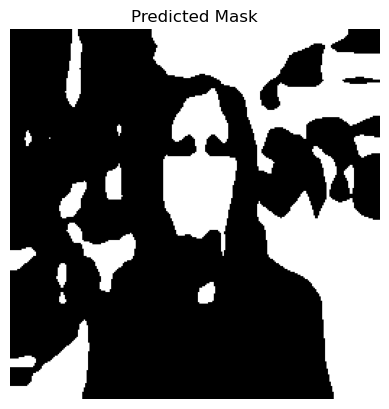

In [14]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

def predict_mask(image_path, model):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
    
    mask = torch.sigmoid(output).squeeze().cpu().numpy()
    mask = (mask > 0.5).astype(np.uint8)  # Convert to binary mask

    return mask

# Test with an image
test_image = "samplex.jpeg"
predicted_mask = predict_mask(test_image, deeplab_model)

plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")
plt.show()


In [29]:
import torch
from torchvision import models

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained DeepLabV3 model with a ResNet backbone
deeplab_model = models.segmentation.deeplabv3_resnet101(pretrained=True).to(device)

# Set the model to evaluation mode
deeplab_model.eval()


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [31]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets

# Define the transform for preprocessing the data
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),          # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet stats
])

# Assuming the dataset is in 'dataset/val_data' with 'Mask' and 'No Mask' folders
val_dataset = datasets.ImageFolder(root='dataset', transform=transform)

# DataLoader for batch processing
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm

def calculate_metrics(model, dataloader, device, threshold=0.5):
    """
    Calculate metrics for semantic segmentation with continuous-valued masks.
    
    Args:
        model: The segmentation model
        dataloader: DataLoader containing images and masks
        device: torch device to use
        threshold: Threshold for binarizing both predictions and masks (default: 0.5)
    
    Returns:
        tuple: (accuracy, precision, recall, f1, iou)
    """
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, leave=False):
            images, masks = images.to(device), masks.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Get predictions
            logits = outputs['out']
            probs = torch.softmax(logits, dim=1)
            
            # For binary segmentation, take channel 1 (foreground)
            # or sum across all channels except background
            preds = probs[:, 1:, :, :].sum(dim=1, keepdim=True)
            
            # Ensure predictions and masks are in range [0, 1]
            preds = torch.clamp(preds, 0, 1)
            masks = torch.clamp(masks, 0, 1)
            
            # Print shapes and value ranges for debugging
            print(f"\nDebug - Batch Statistics:")
            print(f"Predictions shape: {preds.shape}, range: [{preds.min():.4f}, {preds.max():.4f}]")
            print(f"Masks shape: {masks.shape}, range: [{masks.min():.4f}, {masks.max():.4f}]")
            
            # Binarize both predictions and masks using threshold
            preds_binary = (preds > threshold).float()
            masks_binary = (masks > threshold).float()
            
            # Convert to numpy and flatten
            preds_flat = preds_binary.cpu().numpy().reshape(-1)
            masks_flat = masks_binary.cpu().numpy().reshape(-1)
            
            all_preds.append(preds_flat)
            all_labels.append(masks_flat)
    
    # Concatenate all predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    # Print final statistics
    print("\nFinal Statistics:")
    print(f"Total pixels processed: {len(all_preds)}")
    print(f"Positive pixels in predictions: {np.sum(all_preds == 1)}")
    print(f"Positive pixels in masks: {np.sum(all_labels == 1)}")
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    # Calculate IoU (Intersection over Union)
    intersection = np.logical_and(all_preds, all_labels).sum()
    union = np.logical_or(all_preds, all_labels).sum()
    iou = intersection / union if union != 0 else 0.0
    
    return accuracy, precision, recall, f1, iou

# Example usage:
try:
    accuracy, precision, recall, f1, iou = calculate_metrics(
        model=deeplab_model,
        dataloader=train_loader,
        device=device,
        threshold=0.5  # Adjust this threshold based on your needs
    )
    
    print(f"\nEvaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"IoU: {iou:.4f}")

except Exception as e:
    print(f"Error occurred: {str(e)}")
    
    # Get a sample batch for debugging
    images, masks = next(iter(train_loader))
    print(f"\nSample batch information:")
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")
    print(f"Mask value range: [{masks.min():.4f}, {masks.max():.4f}]")
    print(f"Unique mask values: {torch.unique(masks)[:10]}...")